# 环中心分析


In [1]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/dump_225_test.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/rst/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result1 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    # df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    # 增加出除重操作，从粒子中心思想转变为环中心思想
    df = particle_ring_df.copy()
    df['ring_nodes_set'] = df['ring_nodes'].apply(lambda x: frozenset(x))
    valid_df = df.groupby('frame').apply(
        lambda x: x.drop_duplicates(subset=['ring_nodes_set'])
    )
    valid_df = valid_df.reset_index(drop=True)
    valid_df = valid_df.drop("ring_nodes_set", axis=1)
    # df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    df = single_analyzer.find_ring_centers(valid_df, coords, box)
    result1 = pd.concat([result1, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 2501/2501 [03:18<00:00, 12.57it/s]
/tmp/ipykernel_16341/2829547802.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_df = df.groupby('frame').apply(
/tmp/ipykernel_16341/2829547802.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in 

In [2]:
print(result1.head())

   frame  center  ring_len                                         ring_nodes  \
0      0       0         8  (0, 978, 8712, 6570, 8307, 11907, 10791, 10581...   
1      0       0         5                     (0, 978, 8712, 7581, 10095, 0)   
2      0       0         6            (0, 10581, 10170, 4980, 2535, 10095, 0)   
3      0     978         9  (978, 0, 10581, 10791, 11907, 9033, 7566, 8553...   
4      0     978         7      (978, 0, 10095, 7581, 6189, 9222, 11604, 978)   

             pair                        ring_center  
0    (978, 10581)  [38.411575, 31.808123, 22.835526]  
1    (978, 10095)    [40.25864, 30.10856, 23.425419]  
2  (10581, 10095)  [39.456917, 31.891727, 20.372545]  
3       (0, 2406)    [36.85848, 32.760086, 23.93827]  
4      (0, 11604)   [40.382973, 28.65707, 24.037106]  


/tmp/ipykernel_8792/2750946458.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


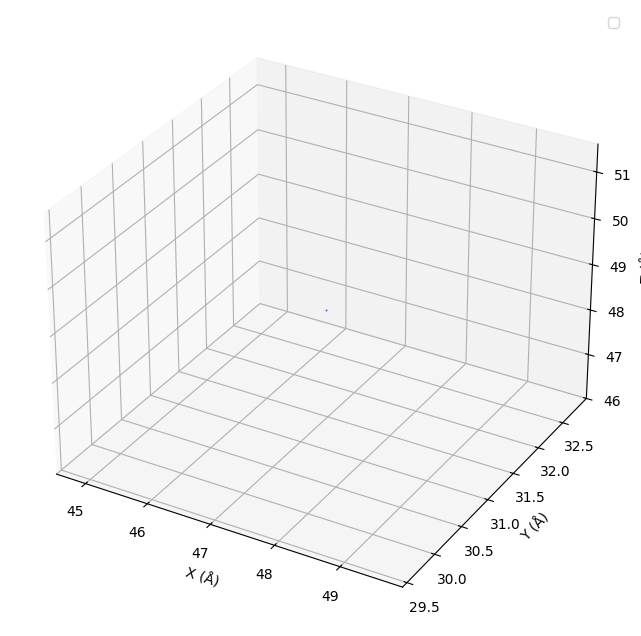

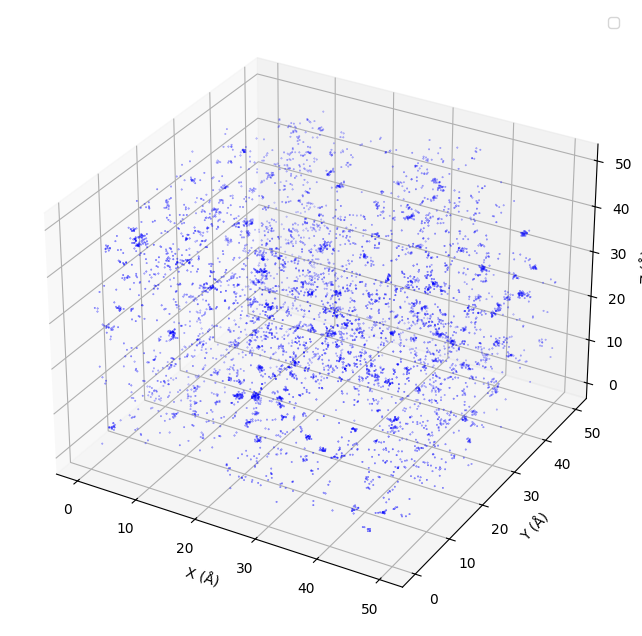

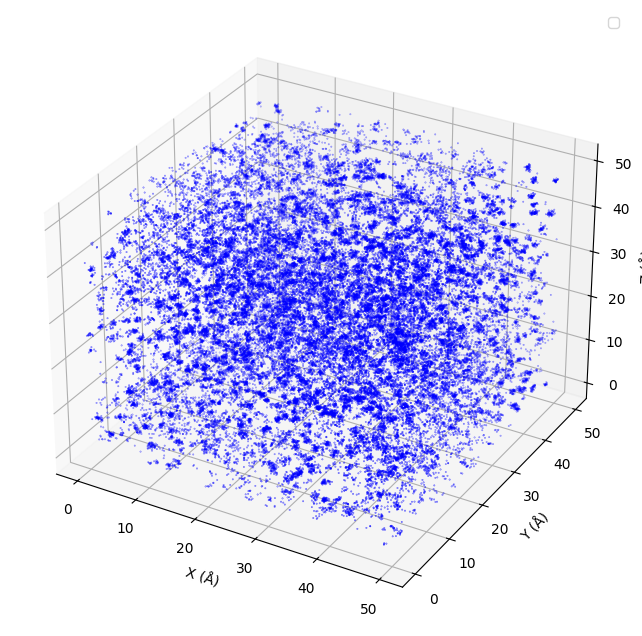

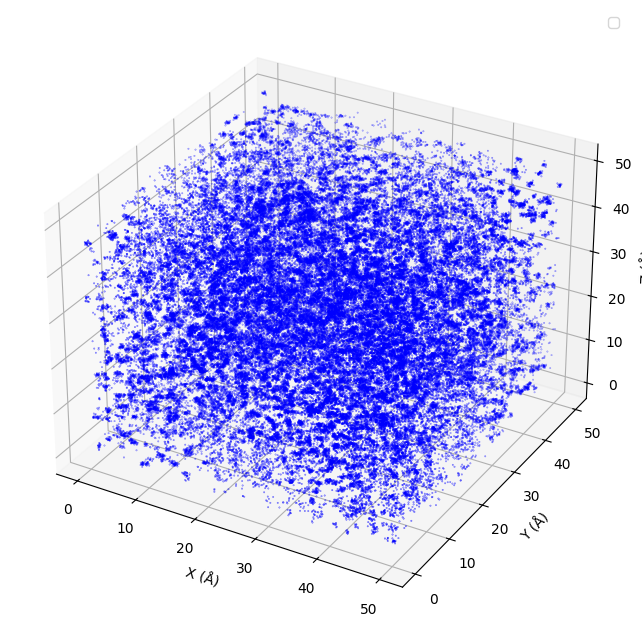

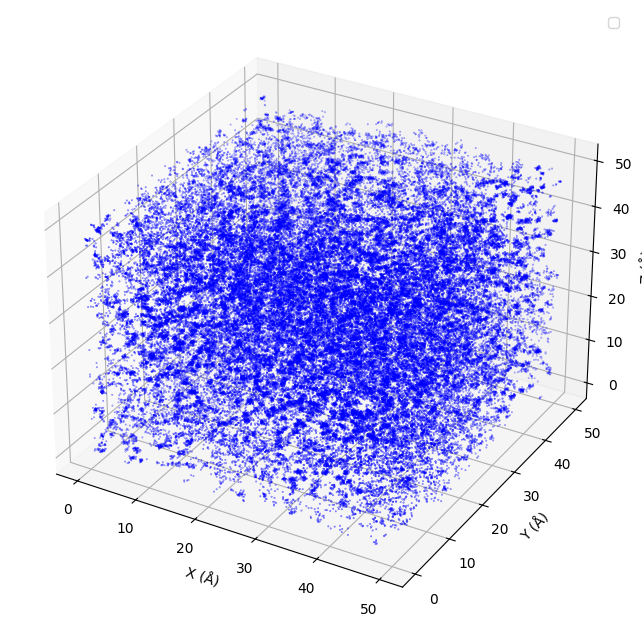

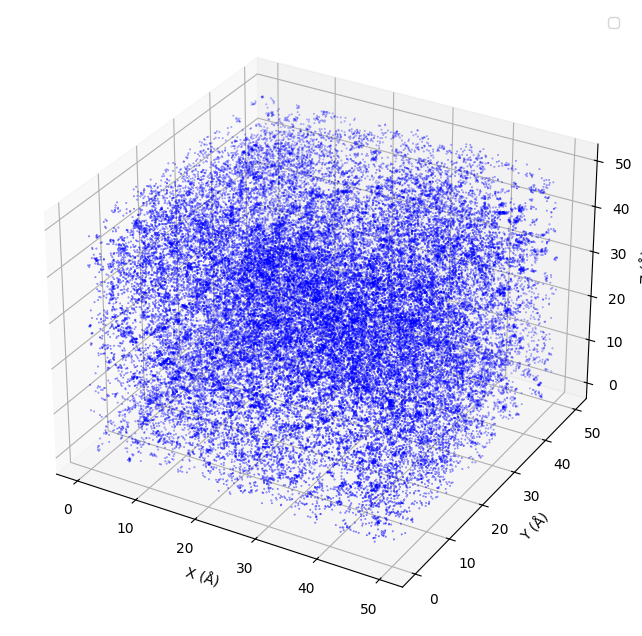

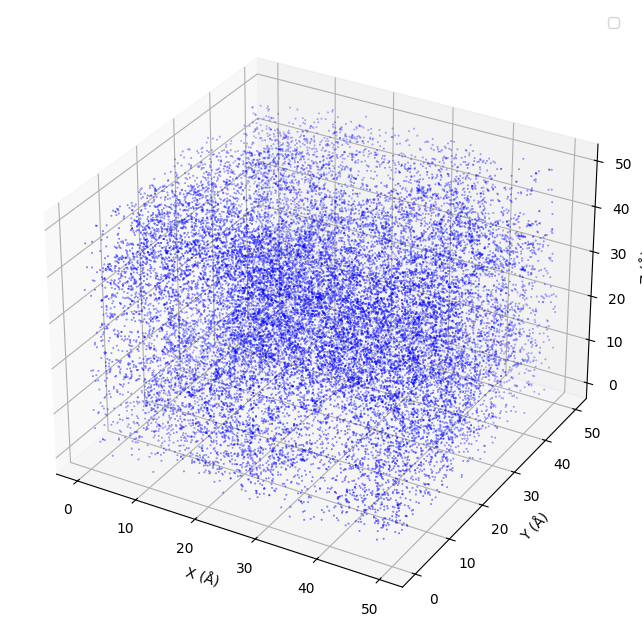

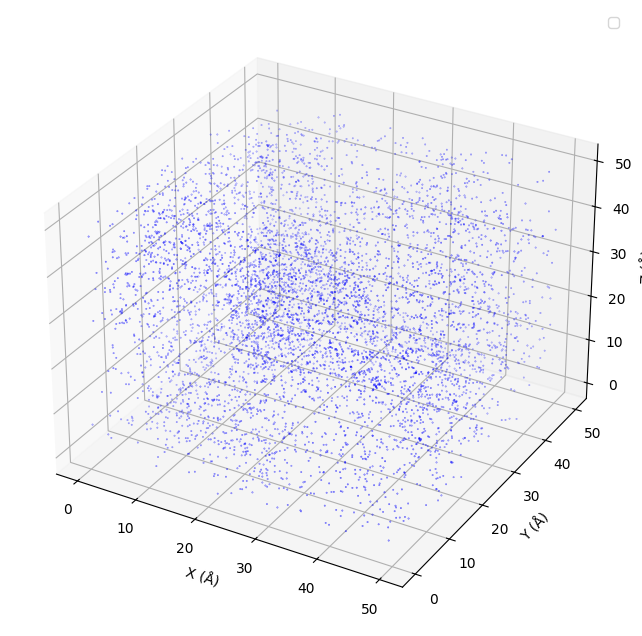

In [3]:
import numpy as np
# 绘制ring_center在不同环长下在空间中的分布情况，检查是否存在不均匀分布
ring_centers = result1.groupby("ring_len")["ring_center"]
import matplotlib.pyplot as plt
for ring_len, group in ring_centers:
    group = np.array(group.tolist())
    # print(np.array(group.tolist()))
    # print(group)
    fig= plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(group[:, 0], group[:, 1], group[:, 2], c='b', s=0.1)
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.legend()
    plt.show()

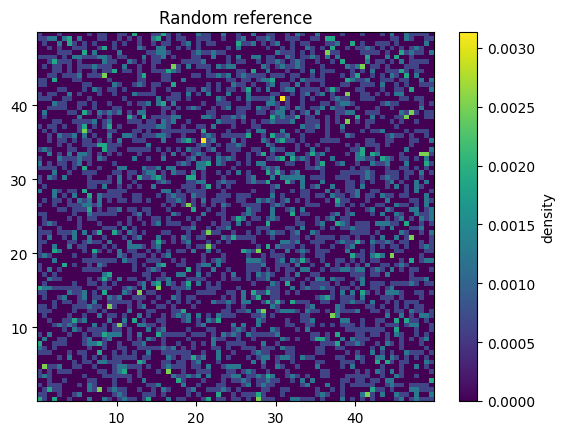

In [4]:
def random_reference_density(n, box, axes=(0,1), bins=80):
    Lx, Ly, Lz = box[:3]
    rand = np.random.rand(n, 3) * np.array([Lx, Ly, Lz])

    # plt.hist2d(
    #     rand[:, axes[0]],
    #     rand[:, axes[1]],
    #     bins=bins,
    #     density=True,
    #     cmap="inferno",
    # )
    y0 = Ly / 2
    dy = 6
    mask = (rand[:, 1] > y0 - dy/2) & (rand[:, 1] <= y0 + dy/2)
    sub = rand[mask]
    plt.hist2d(rand[:, axes[0]], rand[:, axes[1]], bins=bins, density=True)
    plt.colorbar(label="density")
    plt.title("Random reference")
    plt.show()
box = [50,50,50,90,90,90]
random_reference_density(4096, box)

In [2]:
def select_slice(df, z0, dz):
    """
    选择 z ∈ [z0 - dz/2, z0 + dz/2] 的 ring
    """
    centers = np.vstack(df["ring_center"].to_numpy())
    mask = (centers[:,2] >= z0 - dz/2) & (centers[:,2] <= z0 + dz/2)
    return df[mask]


In [3]:
# 绘制空间局部密度分布热图
def plot_2d_density(df, ring_len, axes=(0,1), bins=80):
    sub = select_slice(df[df["ring_len"] == ring_len], z0= 25, dz=6)
    coords = np.vstack(sub["ring_center"].to_numpy())

    x = coords[:, axes[0]]
    y = coords[:, axes[1]]

    # plt.figure(figsize=(5, 4))
    # plt.hist2d(x, y, bins=bins, density=True, cmap="inferno")
    plt.hist2d(x, y, bins=bins, density=True)
    plt.colorbar(label="density")
    plt.xlabel(["x","y","z"][axes[0]])
    plt.ylabel(["x","y","z"][axes[1]])
    plt.title(f"Ring length {ring_len}: density map")
    plt.tight_layout()
    plt.show()

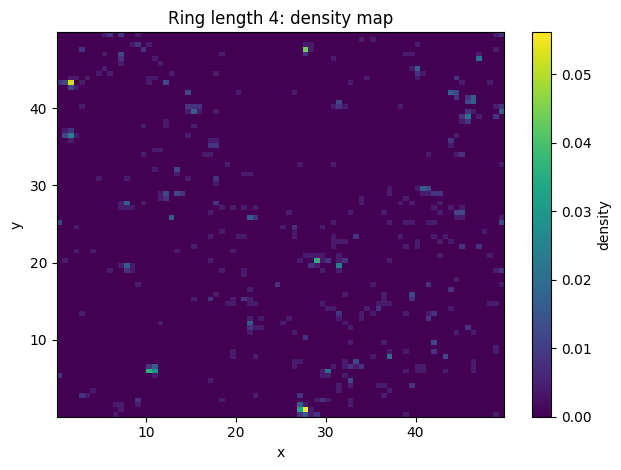

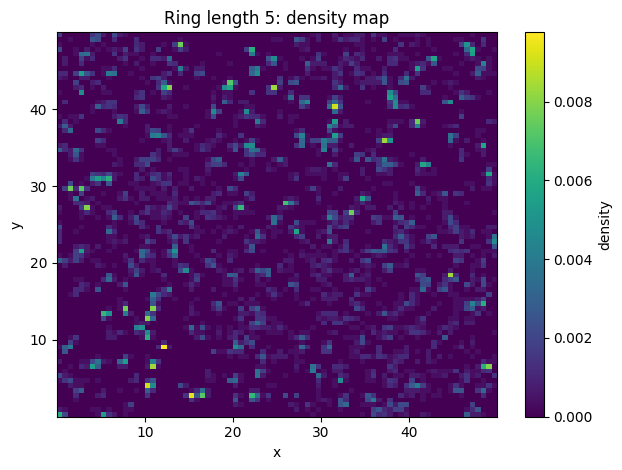

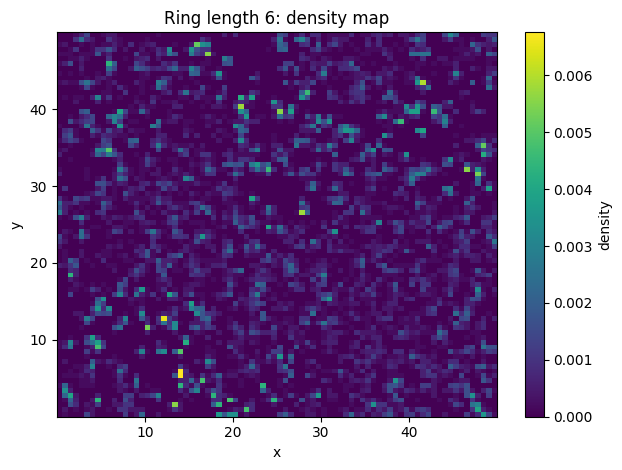

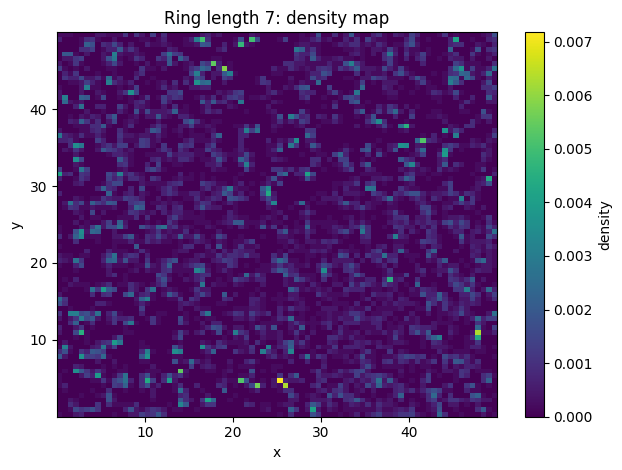

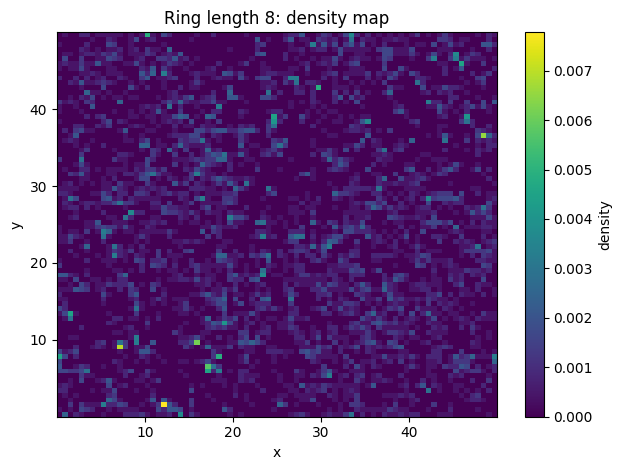

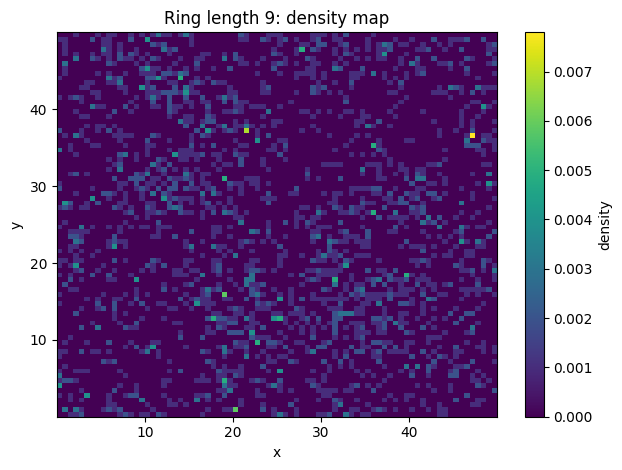

In [7]:
plot_2d_density(result1, 4)
plot_2d_density(result1, 5)
plot_2d_density(result1, 6)
plot_2d_density(result1, 7)
plot_2d_density(result1, 8)
plot_2d_density(result1, 9)

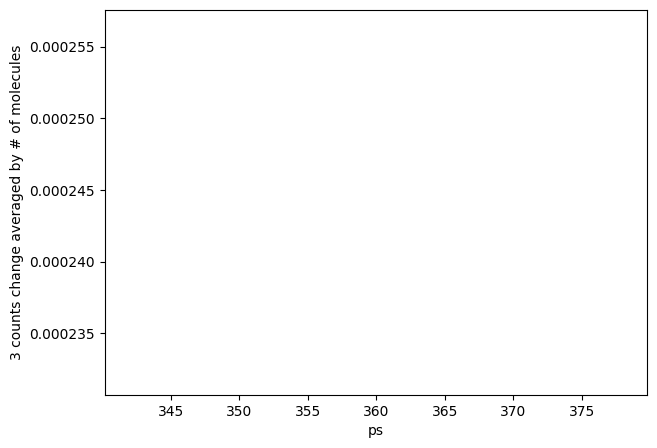

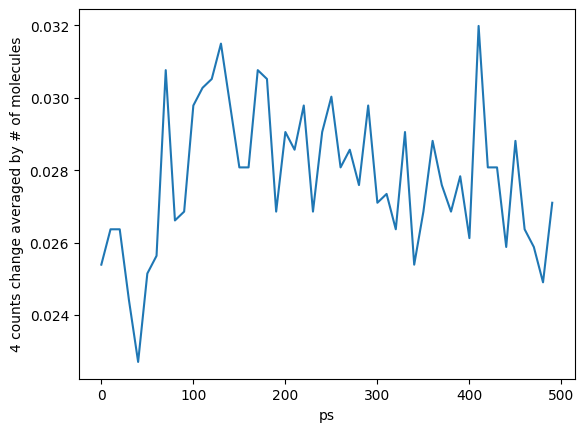

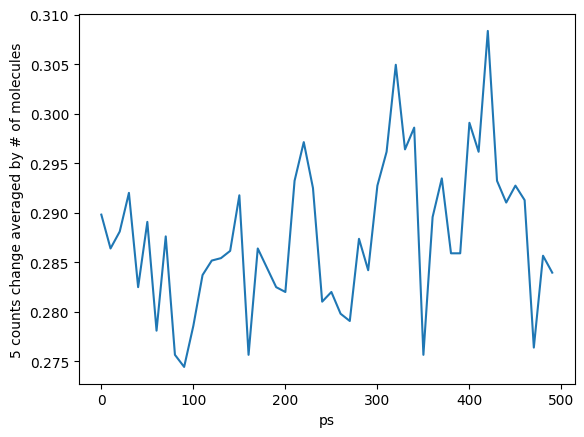

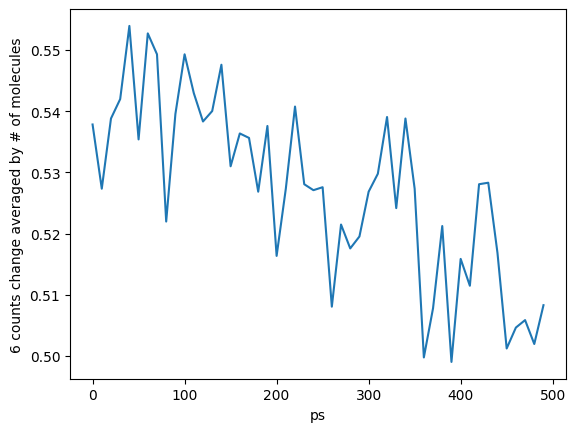

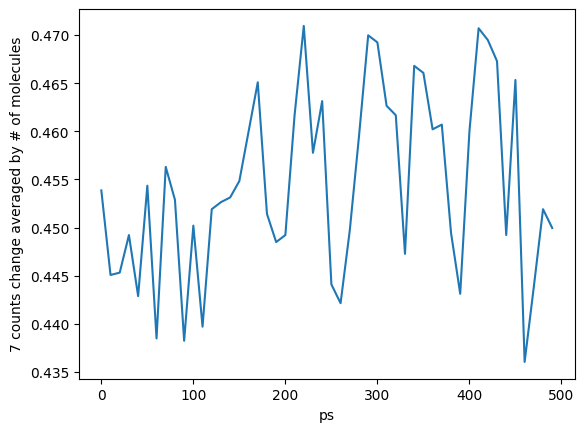

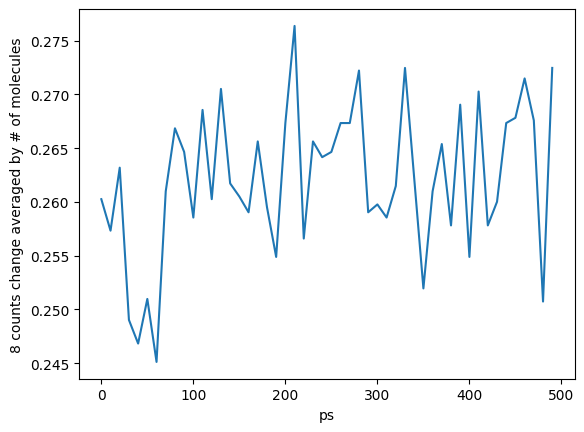

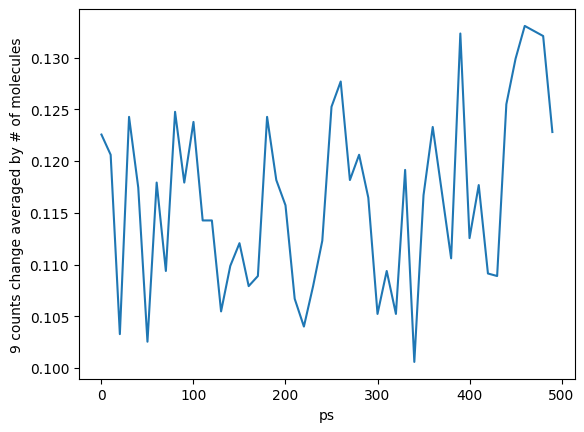

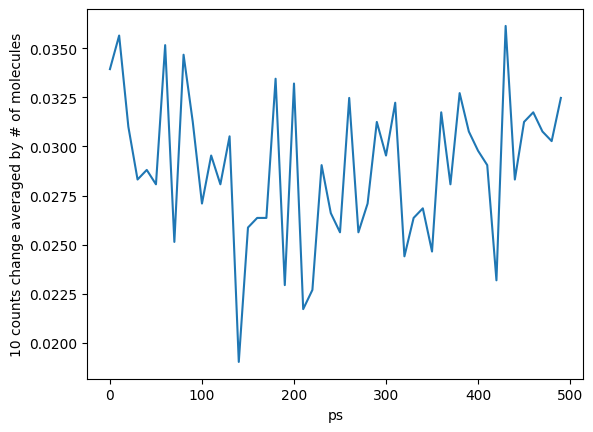

In [14]:
# 观察各环数量变化随时间
ring_counts = result1.groupby(['frame','ring_len']).size().reset_index(name='count')
grouped_ring_counts = ring_counts.groupby('ring_len')
plt.figure(figsize=(7,5))
for ring_len, grouped in grouped_ring_counts:
    plt.plot(grouped['frame']*0.2, grouped['count']/4096)
    plt.xlabel("ps")
    plt.ylabel(f'{ring_len} counts change averaged by # of molecules')
    plt.show()

In [ ]:
# 检查单环的寿命问题
print()

# 增加一个剪切图的slice对照

### 网格映射有问题，不同的strain现在全部映射到了一个方格中，会存在很大的问题

In [8]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_1e-4_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer_shear = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hbonds.h5"
analyzer_shear = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result2 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer_shear.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer_shear.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer_shear.boxes[frame]  # 获取该时间帧的盒子尺寸
    # 增加出除重操作，从粒子中心思想转变为环中心思想
    df = particle_ring_df.copy()
    df['ring_nodes_set'] = df['ring_nodes'].apply(lambda x: frozenset(x))
    valid_df = df.groupby('frame').apply(
        lambda x: x.drop_duplicates(subset=['ring_nodes_set'])
    )
    valid_df = valid_df.reset_index(drop=True)
    valid_df = valid_df.drop("ring_nodes_set", axis=1)
    # df = single_analyzer_shear.add_ring_shape_columns(particle_ring_df, coords, box)
    df = single_analyzer_shear.find_ring_centers(valid_df, coords, box)
    result2 = pd.concat([result2, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [03:30<00:00, 23.76it/s]
/tmp/ipykernel_8792/3446661788.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_df = df.groupby('frame').apply(
/tmp/ipykernel_8792/3446661788.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a 

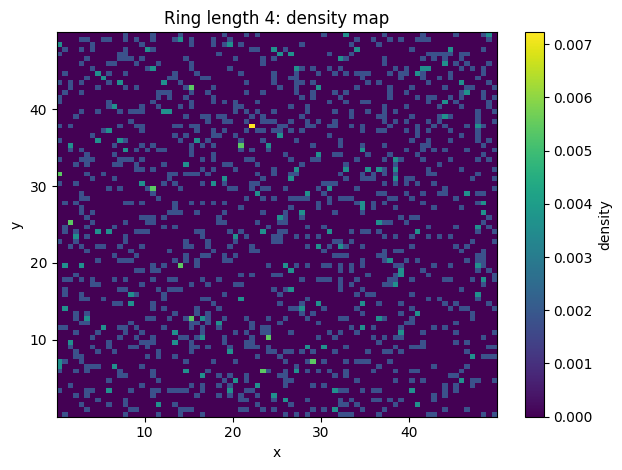

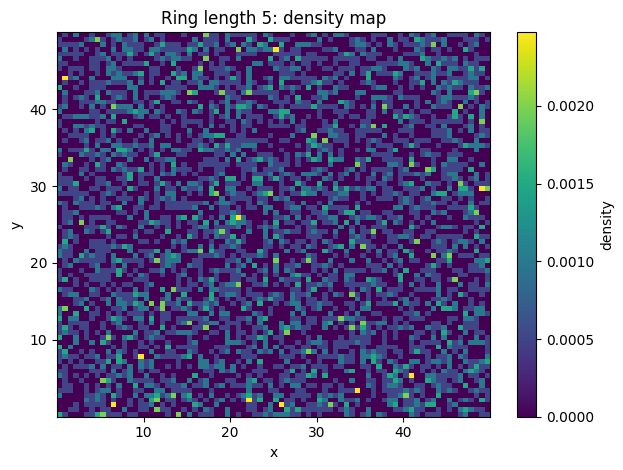

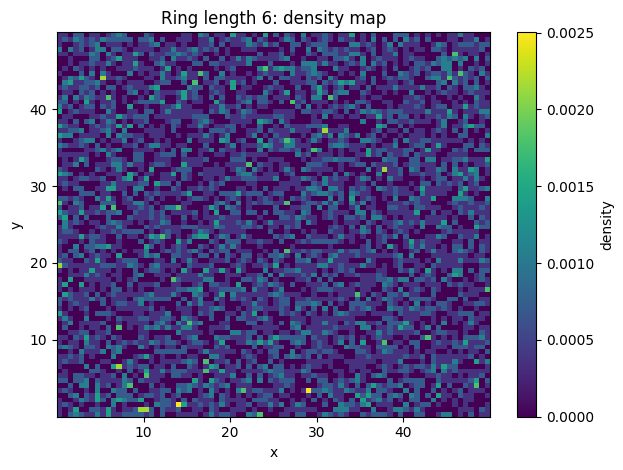

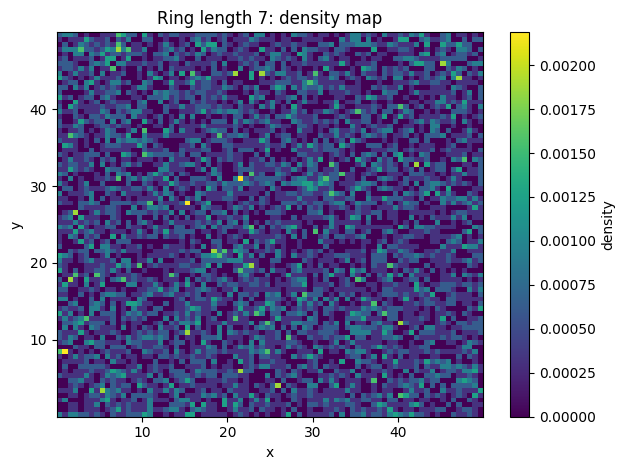

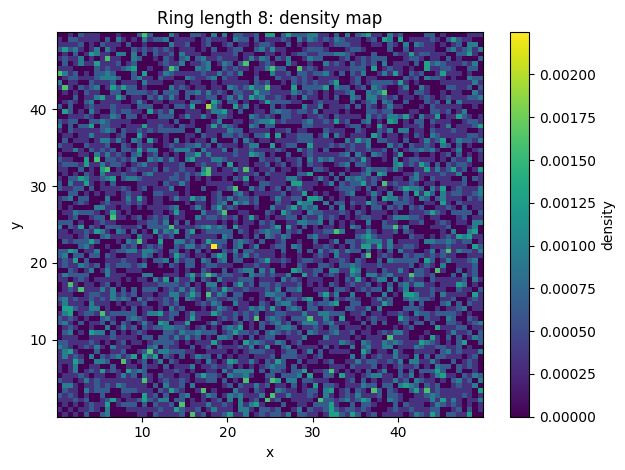

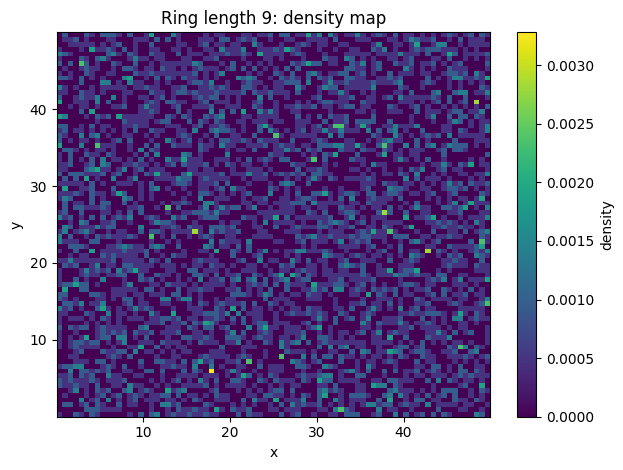

In [9]:
plot_2d_density(result2, 4)
plot_2d_density(result2, 5)
plot_2d_density(result2, 6)
plot_2d_density(result2, 7)
plot_2d_density(result2, 8)
plot_2d_density(result2, 9)

In [2]:
# 对平衡态下的局域结构进行分析
zeta = pd.read_csv("/home/debian/water/TIP4P/Ice/225/rst/zeta.csv")


In [37]:
print(zeta.head())

   frame  O_idx      zeta
0      0      0 -0.184799
1      0      3  0.782048
2      0      6  0.591744
3      0      9  0.347026
4      0     12  0.246825


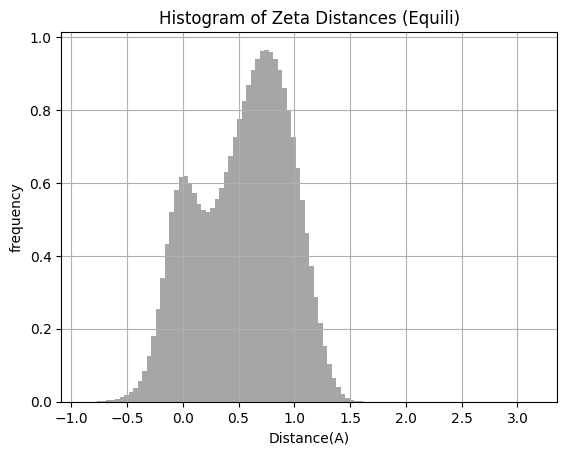

In [39]:
plt.hist(zeta["zeta"], bins=100, density=True, color="grey", alpha=0.7)
plt.title("Histogram of Zeta Distances (Equili)")
plt.xlabel("Distance(A)")
plt.ylabel("frequency")
plt.grid()
plt.show()

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

from scipy.stats import gaussian_kde
from scipy.stats import iqr
from scipy.signal import savgol_filter
def data_smooth(zeta):
        data = zeta["zeta"].values[2000:]
        n = len(data)
                # 使用Silverman法则计算最优带宽
        silverman_bandwidth = 0.9 * min(np.std(data), iqr(data) / 1.34) * n ** (-0.2)
        print(f"Silverman带宽: {silverman_bandwidth:.6f}")
                # 使用高斯核密度估计
        kde = gaussian_kde(data, bw_method=silverman_bandwidth)
        window_length = 51 if n >= 51 else (n // 2) * 2 + 1  # 确保窗口长度为奇数且不超过数据点数
        polyorder = 3 if window_length > 3 else 2  # 多项式阶数小于窗口长度
        plt.figure(figsize=(10, 6))
        x = np.linspace(data.min(), data.max(), 1000)
        smoothed_kde = savgol_filter(kde(x), window_length=window_length, polyorder=polyorder)
                # plt.plot(x, kde(x), "-k", lw=2, label="KDE Estimate")
        plt.plot(x, smoothed_kde, "--b", lw=2, label="Smoothed KDE")
        hist, bin_edges, _ = plt.hist(
                data, bins=300, density=True, alpha=0.3, color="gray", label="Data Histogram"
                )
        plt.axvline(x=0, color="red", linestyle="--", label="ζ=0")
        plt.xlabel("Zeta Distance (nm)")
        plt.ylabel("Probability Density")
        plt.title("Kernel Density Estimation of Zeta Distance")
        plt.legend()
        return smoothed_kde, x
def P_rho(p, zeta):
    return np.exp(-(zeta - p[0])**2/(2 * p[1]**2)) / (p[1] * np.sqrt(2*np.pi))
def mixture_model(zeta, mu1, sigma1, mu2, sigma2, s):
    p1 = [mu1, sigma1]
    p2 = [mu2, sigma2]
    return (1 - s) * P_rho(p1, zeta) + s * P_rho(p2, zeta)
from scipy.optimize import minimize
from scipy.integrate import quad

def objective_function(params, zeta_values, kde_values, zeta_zero_density):
    """目标函数：同时拟合整体分布和ζ=0处的约束"""
    mu1, sigma1, mu2, sigma2, s = params
    
    # 约束1：整体分布拟合误差
    predicted_kde = mixture_model(zeta_values, mu1, sigma1, mu2, sigma2, s)
    fit_error = np.sum((predicted_kde - kde_values)**2)
    
    # 约束2：ζ=0处的密度约束
    density_at_zero = mixture_model(0, mu1, sigma1, mu2, sigma2, s)
    zero_constraint_error = (density_at_zero - zeta_zero_density)**2 * 1000  # 加权
    
    # 约束3：物理合理性约束（可选）
    # 确保sigma为正，s在[0,1]之间
    penalty = 0
    if sigma1 <= 0 or sigma2 <= 0 or s < 0 or s > 1:
        penalty += 1000
    
    return fit_error + zero_constraint_error + penalty

def solve_mixture_model(x, y, zeta_zero_density):
    """解决混合模型参数估计问题"""
    
    # 方法1：基于物理理解的初始猜测
    # 观察您的KDE图形，猜测两个高斯分量的位置
    # 例如：一个在0附近，一个在某个特征位置
    
    # 手动调节寻找峰值作为参考
    peak1_pos = x[np.argmax(y)]
    peak2_pos = 0
    
    
    # 初始参数猜测 [mu1, sigma1, mu2, sigma2, s]
    initial_guess = [peak2_pos, 1.0, peak1_pos, 1.0, 0.3]
    
    # 参数边界
    bounds = [
        (x.min(), x.max()),  # mu1范围
        (0.1, 10),           # sigma1范围
        (x.min(), x.max()),  # mu2范围
        (0.1, 10),           # sigma2范围
        (0, 1)               # s在[0,1]之间
    ]
    
    # 优化
    result = minimize(
        objective_function,
        initial_guess,
        args=(x, y, zeta_zero_density),
        bounds=bounds,
        method='L-BFGS-B',
        options={"maxiter":1000}
    )
    
    if result.success:
        mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt = result.x
        
        # 验证结果
        predicted_at_zero = mixture_model(0, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt)
        fit_quality = np.sqrt(np.mean((mixture_model(x, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt) - y)**2))
        
        print("=== 参数估计结果 ===")
        print(f"第一个高斯分量: μ1 = {mu1_opt:.4f}, σ1 = {sigma1_opt:.4f}")
        print(f"第二个高斯分量: μ2 = {mu2_opt: .4f}, σ2 = {sigma2_opt:.4f}")
        print(f"混合系数 s = {s_opt:.4f} (第二个分量的权重)")
        print(f"约束验证: P(ζ=0) = {predicted_at_zero:.6f} (目标: {zeta_zero_density:.6f})")
        print(f"拟合均方根误差: {fit_quality:.6f}")
        
        return result.x
    else:
        print("优化失败:", result.message)
        return None

# 使用示例
# estimated_params = solve_mixture_model(x, y, zeta_zero_density)

# 可视化结果
def plot_results(x, y, params, zeta_zero_density):
    """绘制拟合结果"""
    mu1, sigma1, mu2,sigma2, s = params
    
    plt.figure(figsize=(12, 8))
    
    # 原始数据
    plt.plot(x, y, 'k-', lw=2, label='原始KDE', alpha=0.7)
    
    # 拟合结果
    y_fit = mixture_model(x, mu1, sigma1, mu2, sigma2, s)
    plt.plot(x, y_fit, 'r--', lw=2, label='双高斯混合拟合')
    
    # 各个分量
    y1 = (1 - s) * P_rho([mu1, sigma1], x)
    y2 = s * P_rho([mu2, sigma2], x)
    plt.plot(x, y1, 'b:', lw=1, label=f'分量1 (权重: {1-s:.3f})')
    plt.plot(x, y2, 'g:', lw=1, label=f'分量2 (权重: {s:.3f})')
    
    # ζ=0处的约束点
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='ζ=0')
    plt.scatter(0, zeta_zero_density, color='red', s=100, zorder=5, 
                label=f'约束点: P(0)={zeta_zero_density:.4f}')
    
    plt.xlabel('Zeta Distance)')
    plt.ylabel('Probability Density')
    plt.title('双高斯混合模型拟合结果')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 调用绘图
# if estimated_params is not None:
#     plot_results(x, y, estimated_params, zeta_zero_density)

Silverman带宽: 0.014575
ζ=0处的真实概率密度值: 0.620095
=== 参数估计结果 ===
第一个高斯分量: μ1 = 0.7281, σ1 = 0.3005
第二个高斯分量: μ2 =  0.0076, σ2 = 0.1796
混合系数 s = 0.2553 (第二个分量的权重)
约束验证: P(ζ=0) = 0.619058 (目标: 0.620095)
拟合均方根误差: 0.020816


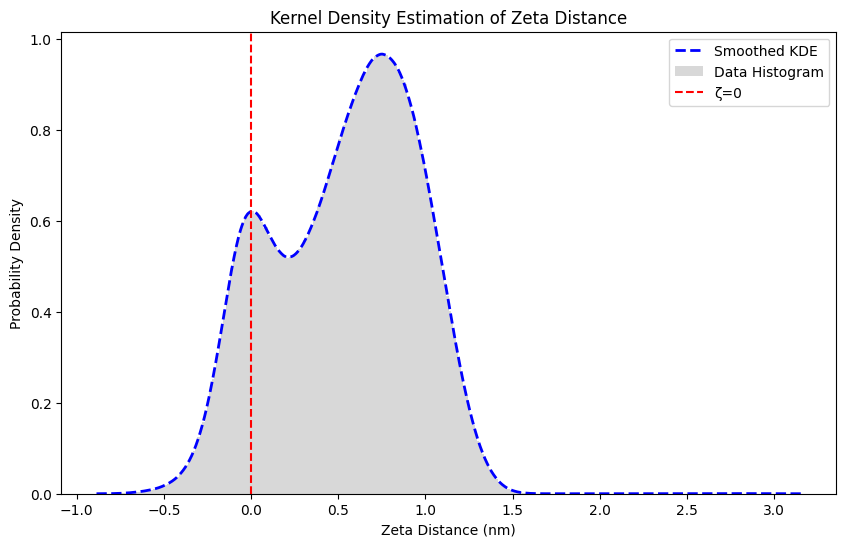

/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

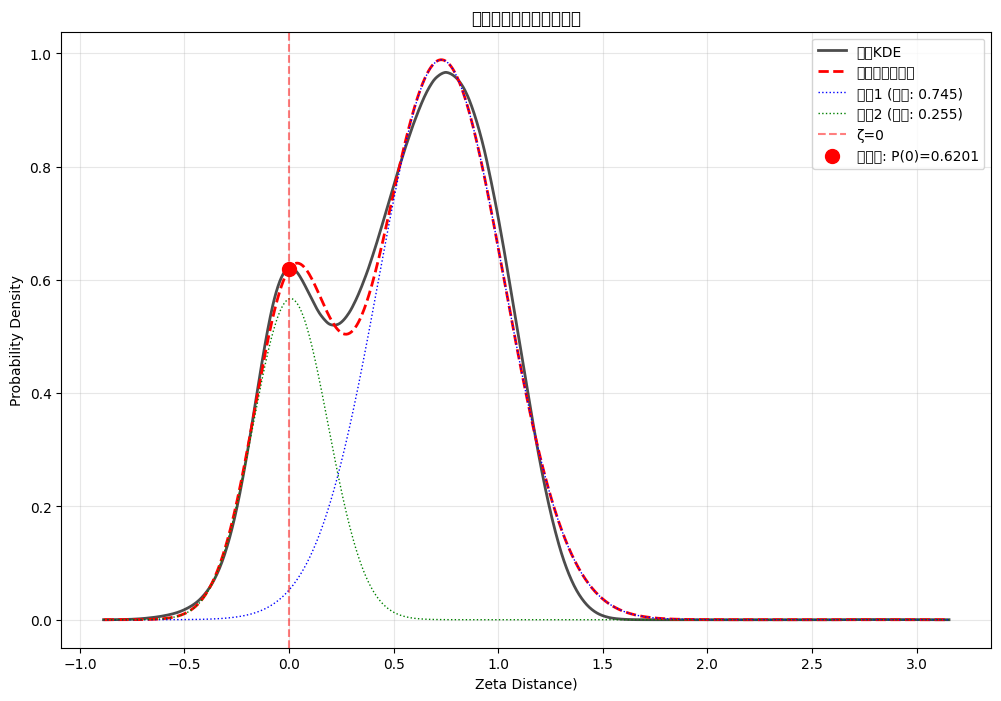

In [43]:
smoothed_kde, x = data_smooth(zeta)
zeta_zero_density = smoothed_kde[np.argmin(np.abs(x-0))]
print(f"ζ=0处的真实概率密度值: {zeta_zero_density:.6f}")
estimated_params = solve_mixture_model(x, smoothed_kde, zeta_zero_density)
plot_results(x, smoothed_kde, estimated_params, zeta_zero_density)

# 研究两种ζcg大小对应的粒子的迁移率如何变化

In [9]:
# 研究平衡态粒子的translation 效应 with tau_chi = 59.4 ps
# 定义\delta r_max(\tau_4)是一个分子在tau_4时间内travels的最大距离
import MDAnalysis as mda
zeta = pd.read_csv("/home/debian/water/TIP4P/Ice/225/rst/zeta.csv")
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/dump_225_test.lammpstrj", format="LAMMPSDUMP")
t_x = 59.4 # ps
dt = 0.2 # ps
tx_frame = t_x // dt
from xi_cg import ZetaCgCalculator
zeta_cg_calculator = ZetaCgCalculator(u,zeta,shear_rate=0,time_step=dt)


/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Precomputing neighbor indices: 100%|██████████| 2501/2501 [08:51<00:00,  4.71it/s]


In [12]:
output_csv = "/home/debian/water/TIP4P/Ice/225/rst/zeta_cg.csv"
for frame_idx, zeta_cg in zeta_cg_calculator.calculate_all_frames():
    with open(output_csv, "a") as f:
        for O_idx, zeta_value in zeta_cg.items():
            f.write(f"{frame_idx},{O_idx},{zeta_value}\n")
print(f"Saved zeta_cg results to {output_csv}")


Calculating zeta_cg for all frames: 100%|██████████| 2501/2501 [03:54<00:00, 10.68it/s]

Saved zeta_cg results to /home/debian/water/TIP4P/Ice/225/rst/zeta_cg.csv


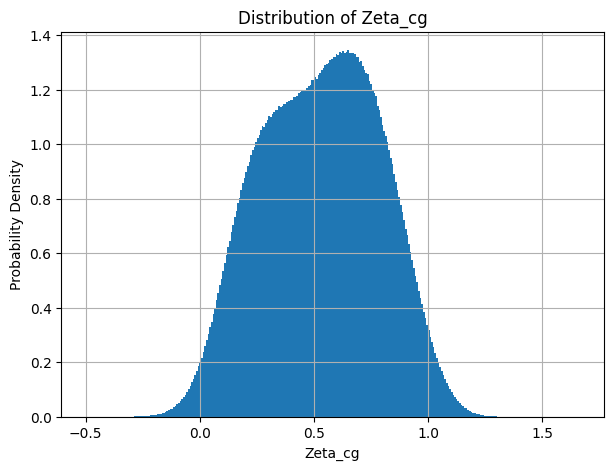

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
output_csv="/home/debian/water/TIP4P/Ice/225/rst/zeta_cg.csv"
df = pd.read_csv(output_csv, names=["frame", "O_idx", "zeta_cg"])
plt.figure(figsize=(7, 5))
plt.hist(df["zeta_cg"], bins=300, density=True)
plt.xlabel("Zeta_cg")
plt.ylabel("Probability Density")
plt.title("Distribution of Zeta_cg")
plt.grid(True)
# plt.savefig("/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta_cg.png", dpi=300)
plt.show()

In [2]:
def calculate_rolling_for_group(group_df, window_size):
    result = group_df.copy()
    result['zeta_cg_rolling_mean']=result['zeta_cg'].rolling(
            window=window_size
        ).mean()
    return result

In [3]:
tx_frame = int(59.4//0.2)
# rolling 取 mean tx_frame时间段内zeta_cg的大小（df.columns=["frame","O_idx","zeta_cg"]）
df_sorted = df.sort_values(["O_idx","frame"]).reset_index(drop=True)
rolling_zeta = df_sorted.groupby("O_idx",group_keys=False).apply(
    lambda x: calculate_rolling_for_group(x, tx_frame)
    )
rolling_zeta.reset_index(drop=True)

/tmp/ipykernel_5568/4064065117.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_zeta = df_sorted.groupby("O_idx",group_keys=False).apply(


frame  O_idx   zeta_cg  zeta_cg_rolling_mean
0             0      0  0.261089                   NaN
1             1      0  0.393281                   NaN
2             2      0  0.298340                   NaN
3             3      0  0.304079                   NaN
4             4      0  0.272334                   NaN
...         ...    ...       ...                   ...
10244091   2496  12285  0.497445              0.487134
10244092   2497  12285  0.674125              0.488492
10244093   2498  12285  0.583305              0.488453
10244094   2499  12285  0.780920              0.488657
10244095   2500  12285  0.355774              0.487989

[10244096 rows x 4 columns]

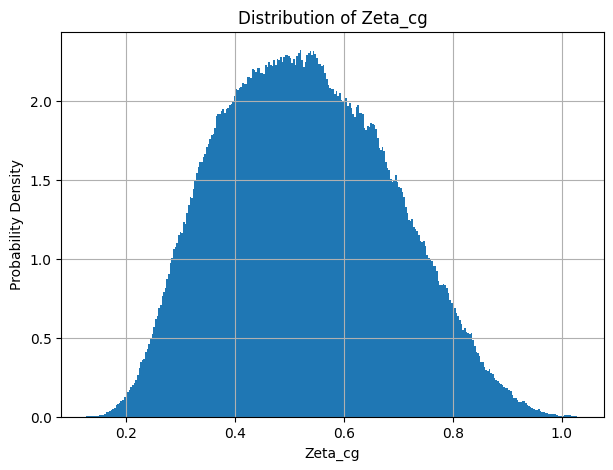

In [4]:
plt.figure(figsize=(7, 5))
plt.hist(rolling_zeta[rolling_zeta["frame"]>=295]["zeta_cg_rolling_mean"], bins=300, density=True)
plt.xlabel("Zeta_cg")
plt.ylabel("Probability Density")
plt.title("Distribution of Zeta_cg")
plt.grid(True)
# plt.savefig("/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta_cg.png", dpi=300)
plt.show()

In [5]:
print(rolling_zeta['O_idx'])

0               0
1               0
2               0
3               0
4               0
            ...  
10244091    12285
10244092    12285
10244093    12285
10244094    12285
10244095    12285
Name: O_idx, Length: 10244096, dtype: int64


### 取前后20% ~ 30%的粒子作为特征粒子来观察其运动特性

In [10]:
import numpy as np
# 修正1：添加括号确保正确的运算顺序
mask1 = (rolling_zeta['frame'] == 295) & (rolling_zeta["zeta_cg_rolling_mean"] < 0.45)
mask2 = (rolling_zeta['frame'] == 295) & (rolling_zeta["zeta_cg_rolling_mean"] > 0.6)

# 修正2：正确提取O_idx
# 假设rolling_zeta中有'O_idx'列
O_idx1 = rolling_zeta.loc[mask1, 'O_idx'].values
O_idx2 = rolling_zeta.loc[mask2, 'O_idx'].values

# 检查提取的O_idx
print(f"满足条件1的O_idx数量: {len(O_idx1)}")
print(f"满足条件2的O_idx数量: {len(O_idx2)}")
if len(O_idx1) > 0:
    print(f"O_idx1示例: {O_idx1[:5]}")
if len(O_idx2) > 0:
    print(f"O_idx2示例: {O_idx2[:5]}")

# 修正3：确保O_idx是整数类型
O_idx1 = O_idx1.astype(int) // 3
O_idx2 = O_idx2.astype(int) // 3

coords = zeta_cg_calculator.coords
print(coords.shape)
ref1 = coords[0, O_idx1]
ref2 = coords[0, O_idx2]


满足条件1的O_idx数量: 1328
满足条件2的O_idx数量: 1396
O_idx1示例: [ 0  6 15 18 21]
O_idx2示例: [33 39 51 66 72]
(2501, 4096, 3)


In [11]:
max_disps = []
# for t0 in range(1, int(coords.shape[0] - tx_frame)):
#     max_disp = np.zeros((4096, ))
#     for t in range(t0, int(tx_frame+t0)):
#         disp = np.linalg.norm(coords[t] - ref, axis=1)
#         max_disp = np.where(disp > max_disp, disp, max_disp)
#     max_disps.append(max_disp)
# max_disps = np.array(max_disps)
t0 = int(0)
max_disp1 = np.zeros((1328,))
max_disp2 = np.zeros((1396,))
for t in range(0, int(1+tx_frame)):
    disp1 = np.linalg.norm(coords[t, O_idx1] - ref1, axis=1)
    disp2 = np.linalg.norm(coords[t, O_idx2] - ref2, axis=1)
    # disp = np.concat(disp1, disp2)
    max_disp1 = np.where(disp1 > max_disp1, disp1, max_disp1)
    max_disp2 = np.where(disp2 > max_disp2, disp2, max_disp2)

max_disps = np.concatenate([max_disp1,max_disp2])
# max_disps.append(max_disp2)

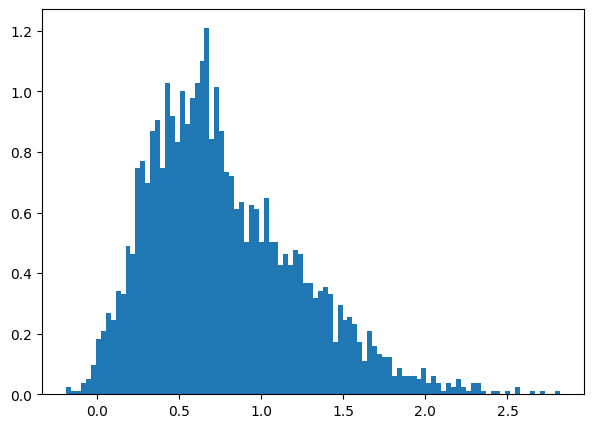

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.hist(np.log2(max_disps), bins=100, density=True)
plt.show()

In [31]:
# 即便如此，我们随意选取5个粒子，观察在t_x时间内它们维持稳态的时间长度。
def quick_O_idx_visualization(rolling_zeta, O_idx_list=None, n_random=5, dt=0.2):
    """
    快速可视化O_idx的zeta值
    """
    
    if O_idx_list is None:
        # 随机选择O_idx
        all_O_idx = sorted(rolling_zeta['O_idx'].unique())
        if n_random > len(all_O_idx):
            n_random = len(all_O_idx)
        
        O_idx_list = np.random.choice(all_O_idx, size=n_random, replace=False)
        O_idx_list = sorted(O_idx_list)
        print(f"随机选择的O_idx: {O_idx_list}")
    
    # 创建单个图形显示所有O_idx
    n_O_idx = len(O_idx_list)
    # fig, axes = plt.subplots(n_O_idx, 1, figsize=(12, 3*n_O_idx))
    
    for idx, O_idx in enumerate(O_idx_list):
        # ax = axes[idx]
        plt.figure(figsize=(12,5))
        
        # 提取数据
        o_data = rolling_zeta[rolling_zeta['O_idx'] == O_idx].sort_values('frame')
        o_data['zeta_cg_binary'] = o_data['zeta_cg'].apply(lambda x: 0 if x < 0.48 else 1)
        if len(o_data) > 0:
            # 绘制两条曲线
            plt.plot(o_data['frame']*0.2/59.4, o_data['zeta_cg_binary'], 'b-', alpha=0.5, label='zeta_cg', linewidth=1)
            plt.title(f'O_idx = {O_idx}', fontsize=11, fontweight='bold')
            plt.xlabel(r'ps/t_4')
            plt.ylabel('zeta')
            plt.legend(loc='upper right')
            plt.grid(True, alpha=0.3)
            plt.xticks([1,2,3,4,5])
            plt.xlim(0,3) 
            plt.tight_layout()
            plt.show()

# 快速使用
# quick_O_idx_visualization(rolling_zeta, n_random=3)
# quick_O_idx_visualization(rolling_zeta, O_idx_list=[0, 50, 100])

随机选择的O_idx: [np.int64(2283), np.int64(5877), np.int64(6990)]


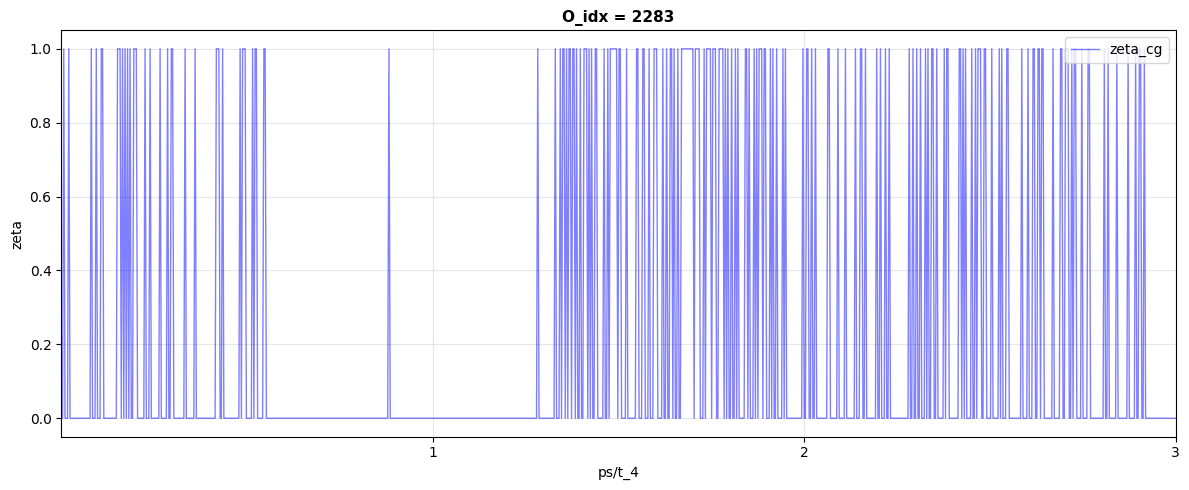

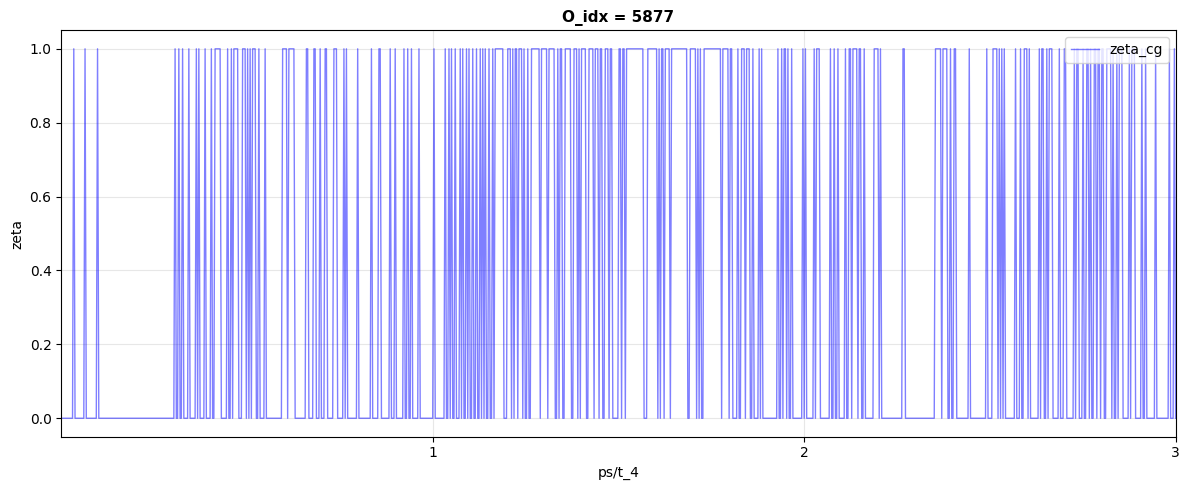

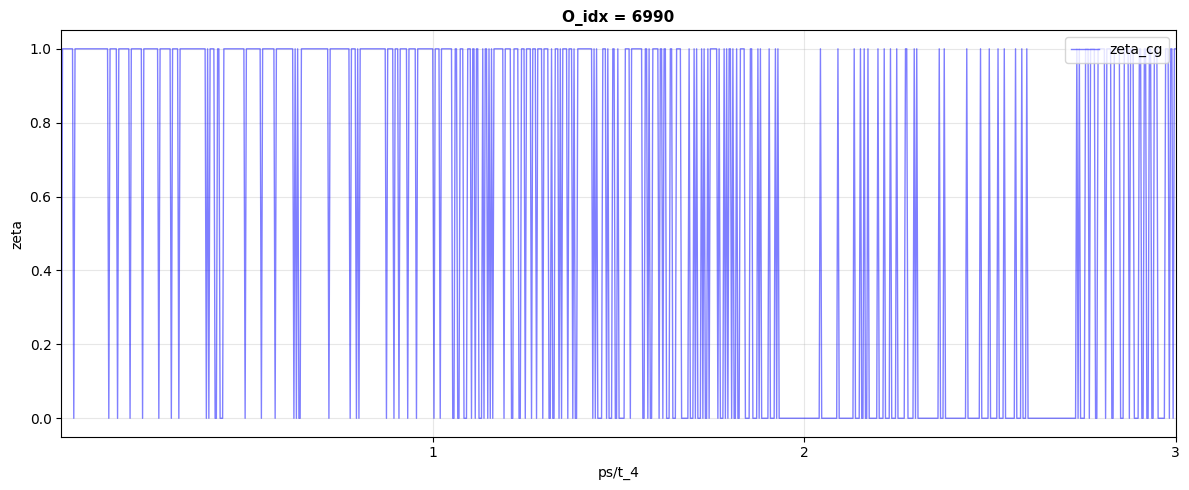

In [32]:
quick_O_idx_visualization(rolling_zeta, n_random=3)

### 定threshold=0.228来进行区分 ρ态和s态

    观察ρ态和s态的局域环

In [3]:
zeta = zeta.copy()
zeta['locality'] = (zeta['zeta'] >= 0.228).astype(int)
# < 0.228 0; >= 0.228 1

In [4]:
result1 = result1.merge(
    zeta[['frame', "O_idx", "locality"]],
    left_on=["frame", "center"],
    right_on=['frame', "O_idx"],
    how="left"
)
result1 = result1.drop(columns=['O_idx'])

In [5]:
print(result1.head())

   frame  center  ring_len                                         ring_nodes  \
0      0       0         8  (0, 978, 8712, 6570, 8307, 11907, 10791, 10581...   
1      0       0         5                     (0, 978, 8712, 7581, 10095, 0)   
2      0       0         6            (0, 10581, 10170, 4980, 2535, 10095, 0)   
3      0     978         9  (978, 0, 10581, 10791, 11907, 9033, 7566, 8553...   
4      0     978         5                   (978, 0, 10095, 7581, 8712, 978)   

             pair                        ring_center  locality  
0    (978, 10581)  [38.411575, 31.808123, 22.835526]         0  
1    (978, 10095)    [40.25864, 30.10856, 23.425419]         0  
2  (10581, 10095)  [39.456917, 31.891727, 20.372545]         0  
3       (0, 2406)    [36.85848, 32.760086, 23.93827]         1  
4       (0, 8712)    [40.25864, 30.10856, 23.425419]         1  


ring_len
3     1.107420e-07
4     5.891473e-04
5     5.268660e-03
6     7.471318e-03
7     4.026910e-03
8     1.802879e-03
9     6.772979e-04
10    1.636766e-04
Name: count, dtype: float64
ring_len
3     4.474438e-08
4     3.903947e-04
5     5.244288e-03
6     8.236479e-03
7     4.047957e-03
8     1.463164e-03
9     5.060813e-04
10    1.115925e-04
Name: count, dtype: float64


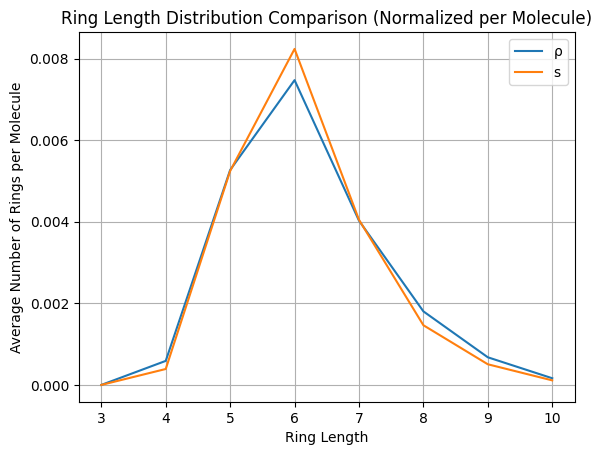

In [10]:
import matplotlib.pyplot as plt
locality_rings = result1.groupby("locality")
local={0:"ρ", 1:"s"}
for locality, rings in locality_rings:
    ring_length_counts = rings["ring_len"].value_counts().sort_index() / len(rings["frame"].unique()) / len(rings)
    print(ring_length_counts)
    plt.plot(ring_length_counts.index, ring_length_counts.values, label=f'{local[locality]}')
plt.title('Ring Length Distribution Comparison (Normalized per Molecule)')
plt.xlabel('Ring Length')
plt.ylabel('Average Number of Rings per Molecule')
plt.xticks(ring_length_counts.index)
plt.grid()
plt.legend()
plt.show()

## 写一个统计环寿命的代码片段

In [2]:
def get_hb_edge_set(hb_df):
    """
    hb_df: 当前帧的氢键表，至少包含 donor, acceptor
    返回: set of frozenset({i,j})
    """
    return set(
        frozenset((row["donor"], row["acceptor"]))
        for _, row in hb_df.iterrows()
    )

In [3]:
def ring_edges_from_nodes(ring_nodes):
    """
    ring_nodes: e.g. (i1, i2, ..., in, i1)
    """
    edges = []
    for i in range(len(ring_nodes)-1):
        edges.append(frozenset((ring_nodes[i], ring_nodes[i+1])))
    return set(edges)

In [4]:
def ring_lifetime(ring_edges, hb_edge_sets, frame_times):
    """
    ring_edges: set of edges defining the ring at t0
    hb_edge_sets: 每一帧的氢键 edge set
    """
    for t, hb_edges in zip(frame_times, hb_edge_sets):
        if not ring_edges.issubset(hb_edges):
            return t
    return frame_times[-1] # survives entire window

In [ ]:
t0 = 1000
ring_df = analyzer.particle_ring_table(frame=t0)
max_frame = int(59.4//0.2) + t0
ring_lifetimes = []
dt = 0.2
for _, row in ring_df.iterrows():
    ring_edges = ring_edges_from_nodes(row["ring_nodes"])

    hb_sets = []
    times = []

    for f in range(t0, max_frame):
        hb_df = analyzer.hbonds_df[analyzer.hbonds_df["frame"] == f]
        hb_sets.append(get_hb_edge_set(hb_df))
        times.append((f - t0) * dt)

    tau = ring_lifetime(ring_edges, hb_sets, times)
    ring_lifetimes.append(tau)


In [1]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/dump_225_test.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/rst/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result1 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result1 = pd.concat([result1, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 2501/2501 [02:42<00:00, 15.35it/s]


In [2]:
print(result1.head())

   frame  center  ring_len                                         ring_nodes  \
0      0       0         8  (0, 978, 8712, 6570, 8307, 11907, 10791, 10581...   
1      0       0         5                     (0, 978, 8712, 7581, 10095, 0)   
2      0       0         6            (0, 10581, 10170, 4980, 2535, 10095, 0)   
3      0     978         9  (978, 0, 10581, 10791, 11907, 9033, 7566, 8553...   
4      0     978         5                   (978, 0, 10095, 7581, 8712, 978)   

             pair  elongation  asphericity  cos2_flow  cos2_extensional  
0    (978, 10581)    0.356476     0.237449   0.314464          0.032764  
1    (978, 10095)    0.234762     0.231453   0.003302          0.437183  
2  (10581, 10095)    0.299212     0.256237   0.078326          0.077150  
3       (0, 2406)    0.161826     0.215296   0.927446          0.752860  
4       (0, 8712)    0.234762     0.231453   0.003302          0.437183  


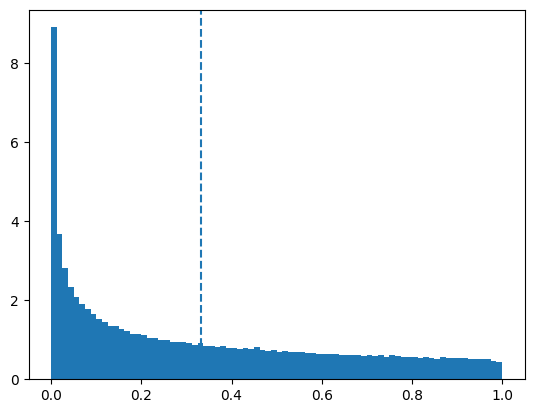

In [3]:
import matplotlib.pyplot as plt
plt.hist(result1["cos2_extensional"], bins=80, density=True)
plt.axvline(1/3, ls="--")
plt.show()

In [5]:
df.groupby("ring_len")[["cos2_flow", "cos2_extensional"]].mean()

cos2_flow  cos2_extensional
ring_len                             
4          0.384208          0.359425
5          0.338396          0.352363
6          0.340644          0.330230
7          0.337470          0.339247
8          0.345702          0.335254
9          0.326181          0.328557
10         0.312493          0.337560

In [8]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_1e-6_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-6/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result2 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result2 = pd.concat([result1, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [05:32<00:00, 15.04it/s]


In [9]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_1e-4_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result3 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result3 = pd.concat([result1, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [05:07<00:00, 16.28it/s]


In [10]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-4_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-4/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result4 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result4 = pd.concat([result1, df], ignore_index=True)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [05:24<00:00, 15.41it/s]


In [20]:
result3[result3['frame'] >= 1000].groupby('ring_len')["cos2_flow"].count()

ring_len
3          3
4      14641
5     174809
6     262705
7     135933
8      51845
9      18646
10      4374
Name: cos2_flow, dtype: int64

In [18]:
# result1.groupby("ring_len")[["cos2_flow", "cos2_extensional"]].mean()
result2[result2['frame'] >= 1000].groupby("ring_len")[["cos2_flow", "cos2_extensional"]].mean()
# result3[result3['frame'] >= 1000].groupby("ring_len")[["cos2_flow", "cos2_extensional"]].mean()
# result4[result4['frame'] >= 1000].groupby("ring_len")[["cos2_flow", "cos2_extensional"]].mean()

cos2_flow  cos2_extensional
ring_len                             
3          0.006909          0.000059
4          0.346533          0.331431
5          0.331879          0.331982
6          0.334913          0.336006
7          0.330750          0.333359
8          0.336964          0.333561
9          0.342113          0.335400
10         0.336043          0.336927